In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Generator, Callable

# Подготовка данных

## Опреределние используемых функций

In [2]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df

def remove_outliers_with_datetime(df: pd.DataFrame, threshold_multiplier: float) -> pd.DataFrame:
    # Копируем DataFrame, чтобы сохранить оригинальные данные
    filtered_df = df.copy()
    # Список для сохранения индексов строк, которые не являются выбросами
    valid_indices = []

    # Проходим по всем столбцам, кроме последнего (DateTime)
    for column in df.columns[:-1]:
        # Вычисление среднего и стандартного отклонения
        mean = df[column].mean()
        std = df[column].std()

        # Определение границ для выбросов
        upper_threshold = mean + threshold_multiplier * std
        lower_threshold = mean - threshold_multiplier * std

        # Находим валидные строки, которые не являются выбросами
        valid_mask = (df[column] <= upper_threshold) & (df[column] >= lower_threshold)
        
        # Сохраняем индексы валидных строк для текущего столбца
        if not valid_indices:
            # Если список индексов еще пуст, инициализируем его
            valid_indices = df.index[valid_mask].tolist()
        else:
            # Объединяем индексы с уже существующими, оставляя только те, которые валидны во всех колонках
            valid_indices = [index for index in valid_indices if index in df.index[valid_mask]]

    # Отфильтровываем DataFrame, оставляя только строки с валидными индексами
    filtered_df = df.loc[valid_indices].reset_index(drop=True)

    return filtered_df


def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()


def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, diff1: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
    X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            # if timeX - timeY < diff2:
            #      tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
            #      X = np.vstack((X, tmp_X))
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
            continue
  
        if (timeY - timeX > diff2) or (timeY - timeX < diff1):
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

## Загрузка файлов

In [3]:
df_Y1 = load_file('Исходные данные/Лабораторные анализы Давление насыщенных паров в продукте, зимний период.xlsx')
df_Y2 = load_file('Исходные данные/Лабораторные анализы Конец кипения легкого бензина.xlsx')
df_Y3 = load_file('Исходные данные/Лабораторные анализы Содержание олефинов в продукте.xlsx')

df_X1 = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx'),2)
df_X2 = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Конец кипения легкого бензина.xlsx'),2)
df_X3 = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Содержание олефинов в продукте.xlsx'),2)

In [4]:
df_Y1

Давление насыщенных паров, зимний период, кПа            DateTime
0                                             49.8 2022-01-01 11:21:00
1                                             52.3 2022-01-02 10:50:00
2                                             50.7 2022-01-03 10:24:48
3                                             52.6 2022-01-04 11:12:49
4                                             54.7 2022-01-05 10:23:28
..                                             ...                 ...
291                                           59.3 2023-12-05 11:30:47
292                                           57.4 2023-12-07 10:21:11
307                                           56.9 2024-01-30 11:27:17
308                                           60.7 2024-02-01 11:17:48
309                                           57.4 2024-02-06 11:46:26

[134 rows x 2 columns]

In [5]:
df_X1

Расход бензина ККР на установку  Расход нафты ККР на установку  \
0                               84.04                           0.07   
1                               79.27                           0.06   
2                               75.37                           0.07   
3                               86.44                           0.26   
4                               85.93                           0.26   
...                               ...                            ...   
8159                           103.80                           0.00   
8160                           103.66                           0.00   
8161                           103.14                           0.00   
8162                           103.68                           0.00   
8163                           101.99                           0.00   

      Расход бензина на рециркуляцию от Е-1205  \
0                                         0.91   
1                                        15.86   
2                                        18.00   
3                                         0.00   
4                                         0.00   
...                                        ...   
8159                                      3.93   
8160                                      1.28   
8161                                      0.20   
8162                                      1.28   
8163                                      0.00   

      Температура бензина ККР на установку  Давление в емкости V-1101  \
0                                    29.06                       1.21   
1                                    28.44                       1.20   
2                                    28.03                       1.20   
3                                    30.50                       1.20   
4                                    30.96                       1.20   
...                                    ...                        ...   
8159                                 35.60                       1.20   
8160                                 35.85                       1.20   
8161                                 35.53                       1.20   
8162                                 35.54                       1.20   
8163                                 35.35                       1.20   

      Расход сырья после Р-1101  Показатель соотношения водород к углероду  \
0                        125.18                                       7.11   
1                        124.85                                       7.13   
2                        124.93                                       7.13   
3                        124.96                                       6.41   
4                        125.01                                       6.40   
...                         ...                                        ...   
8159                     143.04                                       5.53   
8160                     142.90                                       5.52   
8161                     143.09                                       5.53   
8162                     143.59                                       5.50   
8163                     144.18                                       5.48   

      Расход водорода на смешение перед Е-1101  \
0                                       890.10   
1                                       889.73   
2                                       889.68   
3                                       800.28   
4                                       800.20   
...                                        ...   
8159                                    789.95   
8160                                    789.97   
8161                                    789.97   
8162                                    790.03   
8163                                    790.01   

      Температура сырья перед Е-1101  Давление сырья перед Е-1101  ...  \
0                              30.07               

В загруженных файлах заменены пропуски, которые в таблице обозначены "-" на NaN значения, эти строки отброшены.

## Анализ данных

In [6]:
pd.set_option('display.max_columns', None)
min_var = 0.01

In [7]:
def dataframe_info(df):
    df = df.drop(columns=['DateTime'])
    variance = df.var()
    std = df.std()
    means = df.mean()
    medians = df.median()
    mins = df.min()
    maxes = df.max()
    df_info = pd.DataFrame([variance, std, means, medians, mins, maxes], index=['variance', 'standart deviation', 'mean', 'median', 'min', 'max'])
    return df_info

def drop_low_variance(df, df_info, min_var):
    df2 = df[df.columns[:-1]].T
    m1 = df_info.loc['variance'] < min_var
    drop_cols =  df2.loc[m1].T.columns
    df.drop(columns=list(drop_cols), inplace=True)

Простоим таблицу основных статистических величин для каждой переменной в каждом датасете, отбросим те величины, дисперсия которых меньше чем min_var, постоим графики плотности распределения каждой из сотавшихся величин

## X1

In [8]:
df_info_X1 = dataframe_info(df_X1)
df_info_X1

Расход бензина ККР на установку  \
variance                                 164.434290   
standart deviation                        12.823193   
mean                                     100.950884   
median                                   102.100000   
min                                       53.650000   
max                                      127.690000   

                    Расход нафты ККР на установку  \
variance                                 0.002790   
standart deviation                       0.052818   
mean                                     0.012462   
median                                   0.000000   
min                                      0.000000   
max                                      1.240000   

                    Расход бензина на рециркуляцию от Е-1205  \
variance                                           20.454116   
standart deviation                                  4.522623   
mean                                                2.151967   
median                                              0.000000   
min                                                 0.000000   
max                                                20.410000   

                    Температура бензина ККР на установку  \
variance                                        4.709950   
standart deviation                              2.170242   
mean                                           35.478275   
median                                         35.640000   
min                                            26.090000   
max                                            40.230000   

                    Давление в емкости V-1101  Расход сырья после Р-1101  \
variance                             0.000119                 180.072897   
standart deviation                   0.010895                  13.419124   
mean                                 1.198275                 142.526563   
median                               1.200000                 141.140000   
min                                  1.120000                 122.740000   
max                                  1.290000                 181.940000   

                    Показатель соотношения водород к углероду  \
variance                                             0.634180   
standart deviation                                   0.796354   
mean                                                 5.812076   
median                                               5.940000   
min                                                  4.050000   
max                                                  7.620000   

                    Расход водорода на смешение перед Е-1101  \
variance                                        23285.945056   
standart deviation                                152.597330   
mean                                              831.172461   
median                                            869.840000   
min                                               549.850000   
max                                              1109.240000   

                    Температура сырья перед Е-1101  \
variance                                  5.192814   
standart deviation                        2.278775   
mean                                     37.758754   
median                                   38.020000   
min                                      28.090000   
max                                      43.670000   

                    Давление сырья перед Е-1101  \
variance                               0.009574   
standart deviation                     0.097849   
mean                                  29.052329   
median                                29.060000   
min                                   26.100000   
max                                   29.230000   

                    Температура сырья перед Е-1102  \
variance                                  9.874431   
standart deviation                        3.142361   
mean                                    108.357771   
m

In [9]:
drop_low_variance(df_X1, df_info_X1, min_var)

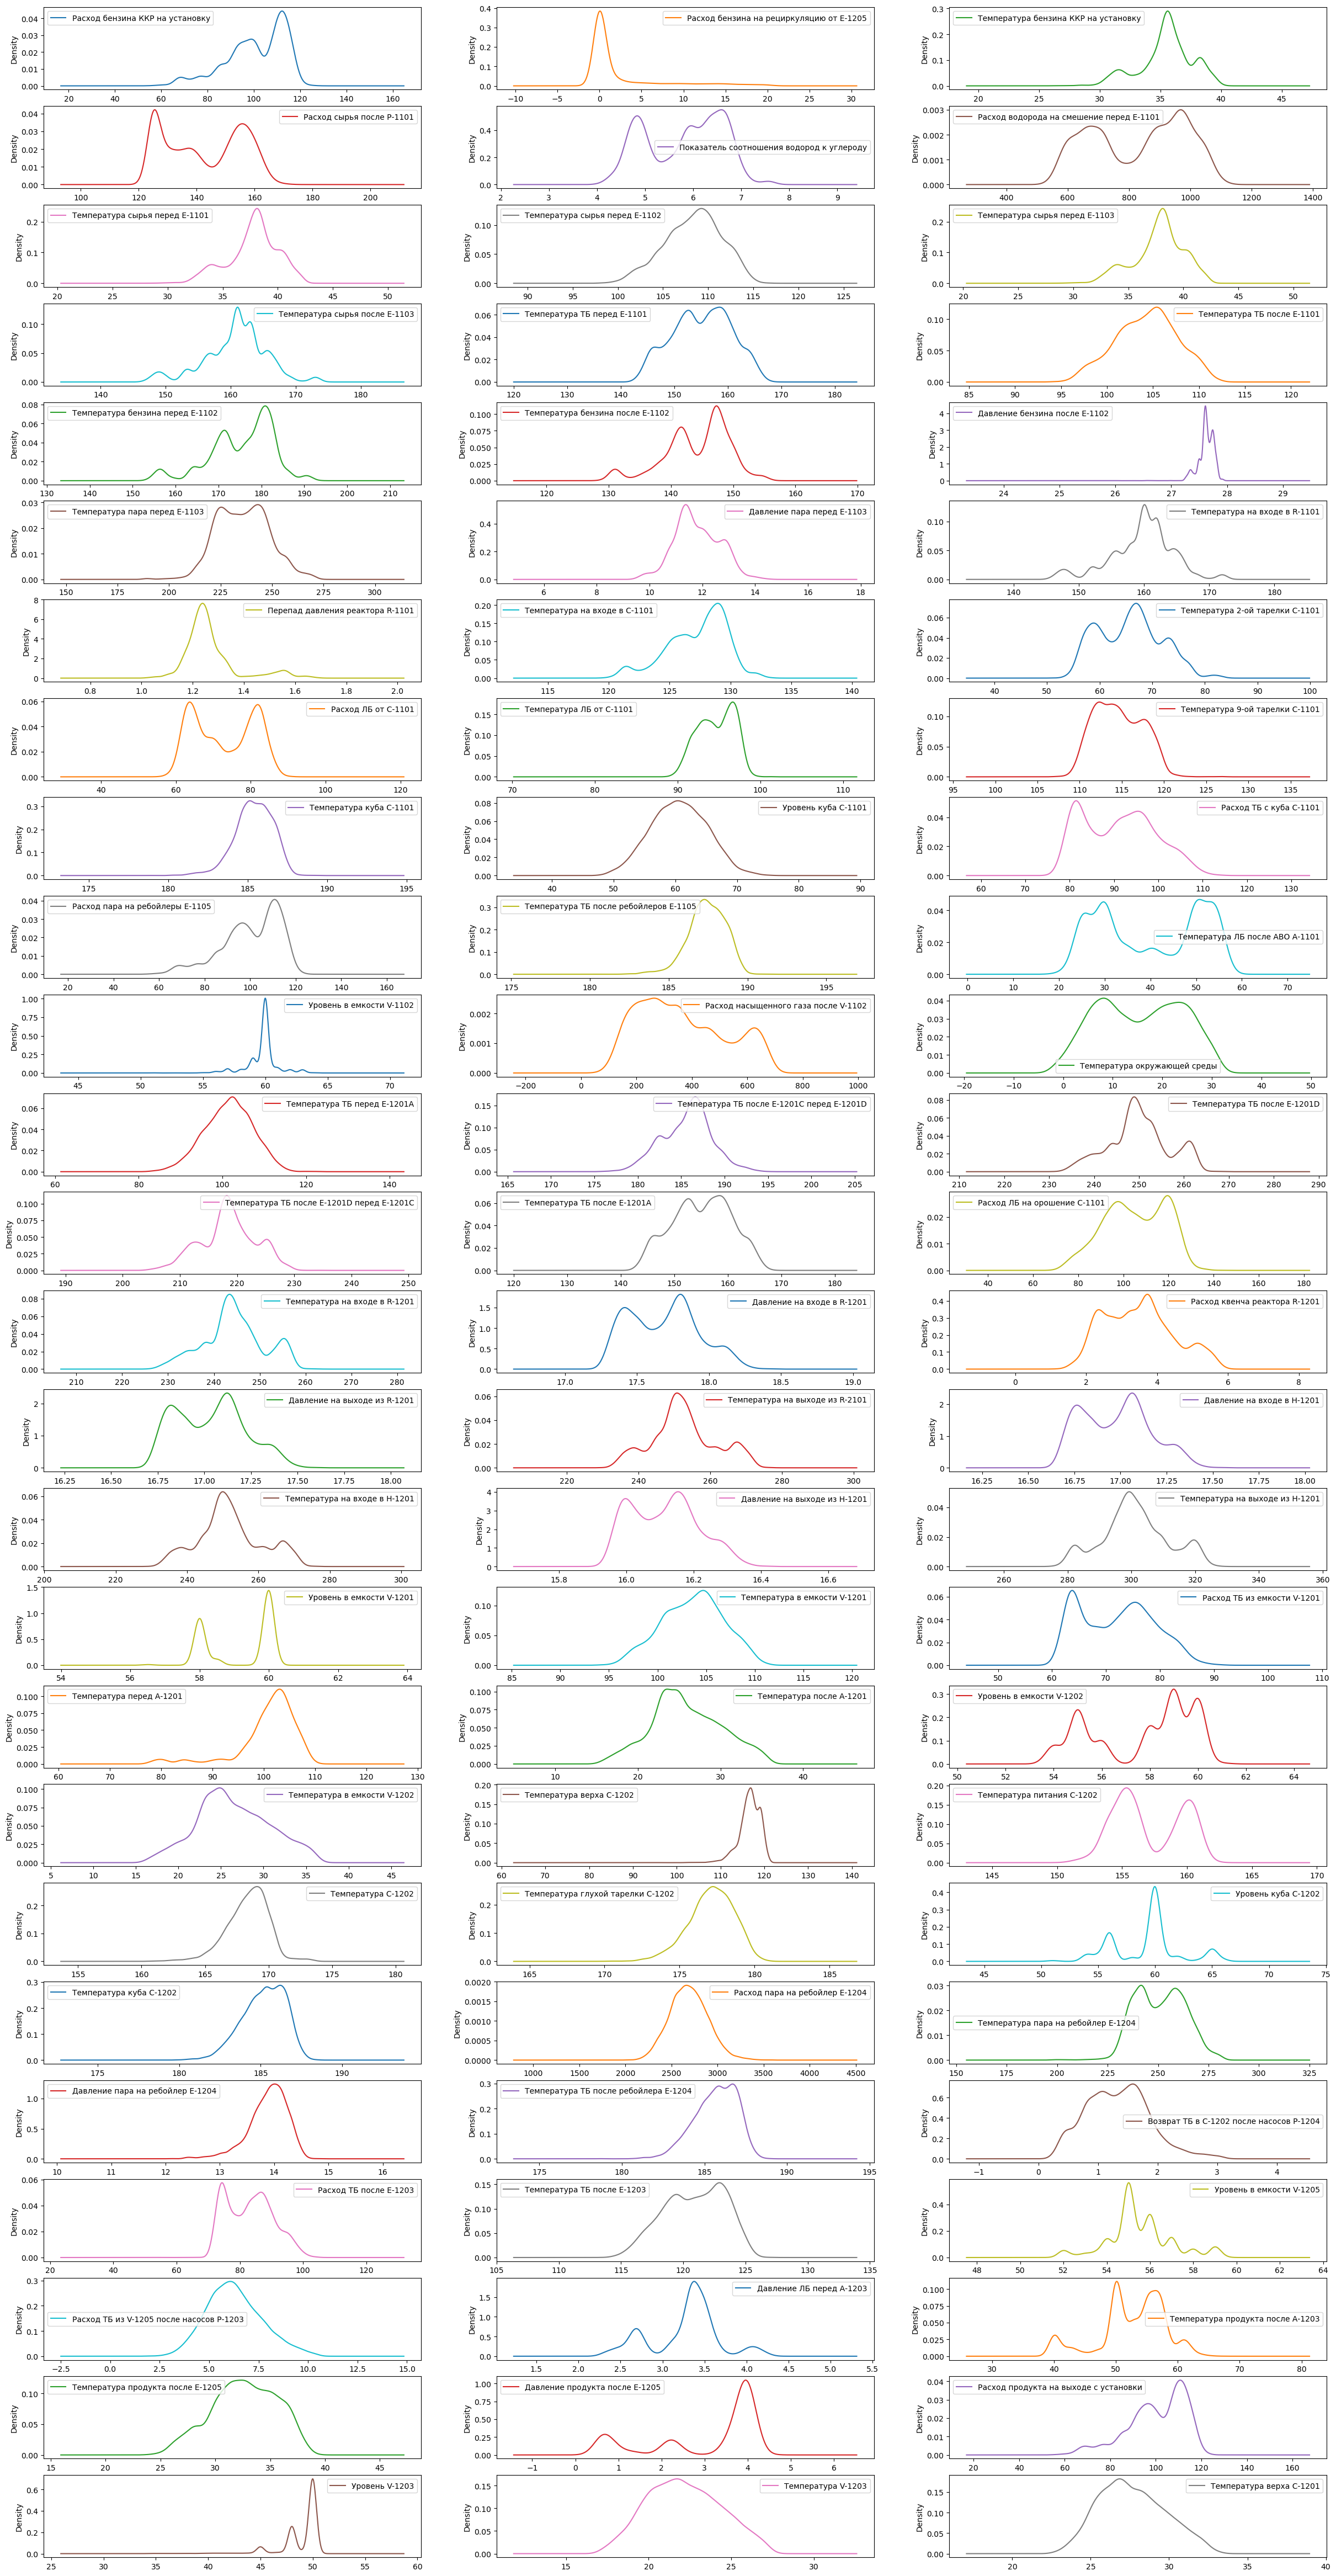

In [10]:
df_X1[df_X1.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X2

In [11]:
df_info_X2 = dataframe_info(df_X2)
df_info_X2

Расход бензина ККР на установку  \
variance                                 171.742471   
standart deviation                        13.105055   
mean                                     100.903536   
median                                   102.220000   
min                                       53.650000   
max                                      125.940000   

                    Расход нафты ККР на установку  \
variance                                 0.004311   
standart deviation                       0.065655   
mean                                     0.014619   
median                                   0.000000   
min                                      0.000000   
max                                      1.310000   

                    Расход бензина на рециркуляцию от Е-1205  \
variance                                           21.988823   
standart deviation                                  4.689224   
mean                                                2.276435   
median                                              0.000000   
min                                                 0.000000   
max                                                20.410000   

                    Температура бензина ККР на установку  \
variance                                        5.061908   
standart deviation                              2.249869   
mean                                           35.311945   
median                                         35.560000   
min                                            26.090000   
max                                            40.230000   

                    Давление в емкости V-1101  Расход сырья после Р-1101  \
variance                             0.000132                 186.003305   
standart deviation                   0.011470                  13.638303   
mean                                 1.198003                 142.648694   
median                               1.200000                 141.500000   
min                                  1.120000                 122.740000   
max                                  1.290000                 181.940000   

                    Показатель соотношения водород к углероду  \
variance                                             0.632285   
standart deviation                                   0.795163   
mean                                                 5.826800   
median                                               5.930000   
min                                                  4.040000   
max                                                  7.670000   

                    Расход водорода на смешение перед Е-1101  \
variance                                        22316.891159   
standart deviation                                149.388390   
mean                                              833.309269   
median                                            869.980000   
min                                               549.850000   
max                                              1109.240000   

                    Температура сырья перед Е-1101  \
variance                                  5.530553   
standart deviation                        2.351713   
mean                                     37.599766   
median                                   37.910000   
min                                      28.090000   
max                                      43.670000   

                    Давление сырья перед Е-1101  \
variance                               0.011011   
standart deviation                     0.104933   
mean                                  29.050825   
median                                29.060000   
min                                   26.100000   
max                                   29.240000   

                    Температура сырья после Е-1103  \
variance                                 21.472451   
standart deviation                        4.633838   
mean                                    160.730462   
m

In [12]:
drop_low_variance(df_X2, df_info_X2, min_var)

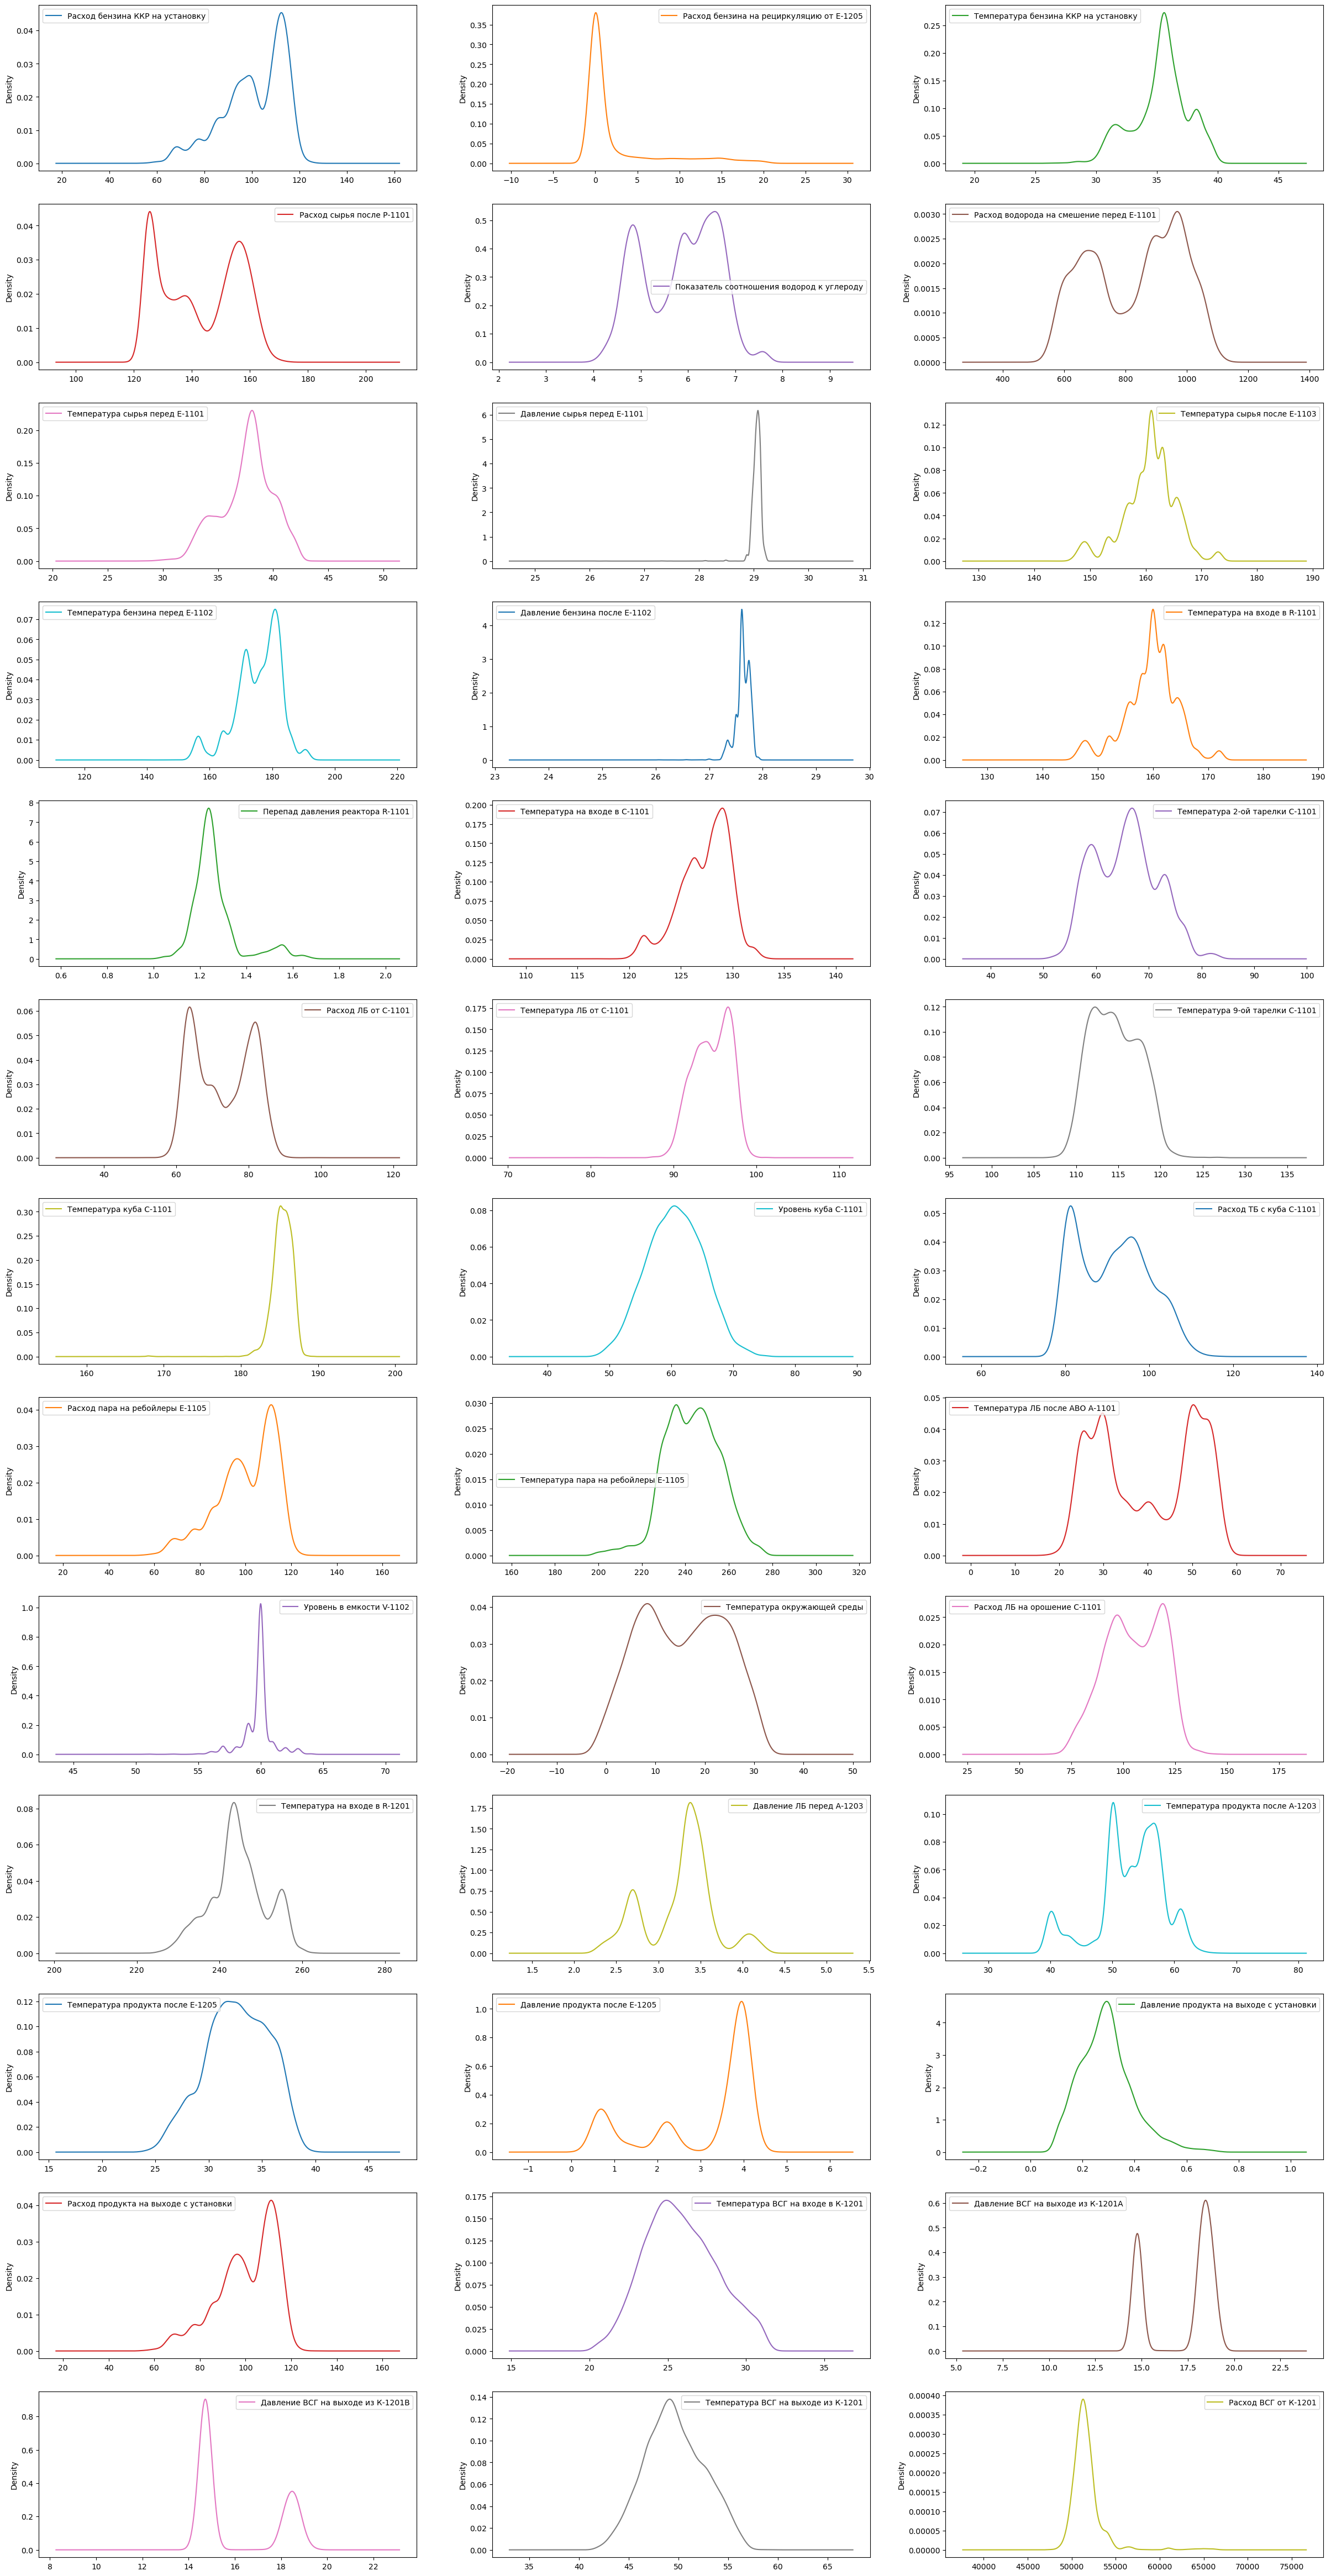

In [13]:
df_X2[df_X2.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X3

In [14]:
df_info_X3 = dataframe_info(df_X3)
df_info_X3

4FI3401_DACA_PV/Var/MV/Расход бензина ККР на установку/  \
variance                                                   164.264171         
standart deviation                                          12.816558         
mean                                                       100.919184         
median                                                     102.000000         
min                                                         53.650000         
max                                                        127.690000         

                    4FI3402_DACA_PV/Var/MV/Расход нафты ККР на установку/  \
variance                                                     0.002775       
standart deviation                                           0.052676       
mean                                                         0.012398       
median                                                       0.000000       
min                                                          0.000000       
max                                                          1.240000       

                    4FIC1002_PIDA_PV/Var/MV/Расход бензина на рециркуляцию от Е-1205/  \
variance                                                    20.493102                   
standart deviation                                           4.526931                   
mean                                                         2.158804                   
median                                                       0.000000                   
min                                                          0.000000                   
max                                                         20.410000                   

                    4TI1002_DACA_PV/Var/MV/Температура бензина ККР на установку/  \
variance                                                     4.698022              
standart deviation                                           2.167492              
mean                                                        35.478006              
median                                                      35.640000              
min                                                         26.090000              
max                                                         40.230000              

                    4PIC1035A_PIDA_PV/Var/MV/Давление в емкости V-1101/  \
variance                                                     0.000118     
standart deviation                                           0.010867     
mean                                                         1.198281     
median                                                       1.200000     
min                                                          1.120000     
max                                                          1.290000     

                    4FIC1010_PIDA_PV/Var/MV/Расход сырья после Р-1101/  \
variance                                                   180.341389    
standart deviation                                          13.429125    
mean                                                       142.473667    
median                                                     141.040000    
min                                                        122.740000    
max                                                        181.940000    

                    4FFIC1003_RATIOCTLA_SP/Var/MV/Показатель соотношения водород к углероду/  \
variance                                                     0.631471                          
standart deviation                                           0.794651                          
mean                                                         5.812793                          
median                                                       5.940000                          
min                                                          4.050000                          
max                                                          7.620000                       

In [15]:
drop_low_variance(df_X3, df_info_X3, min_var)

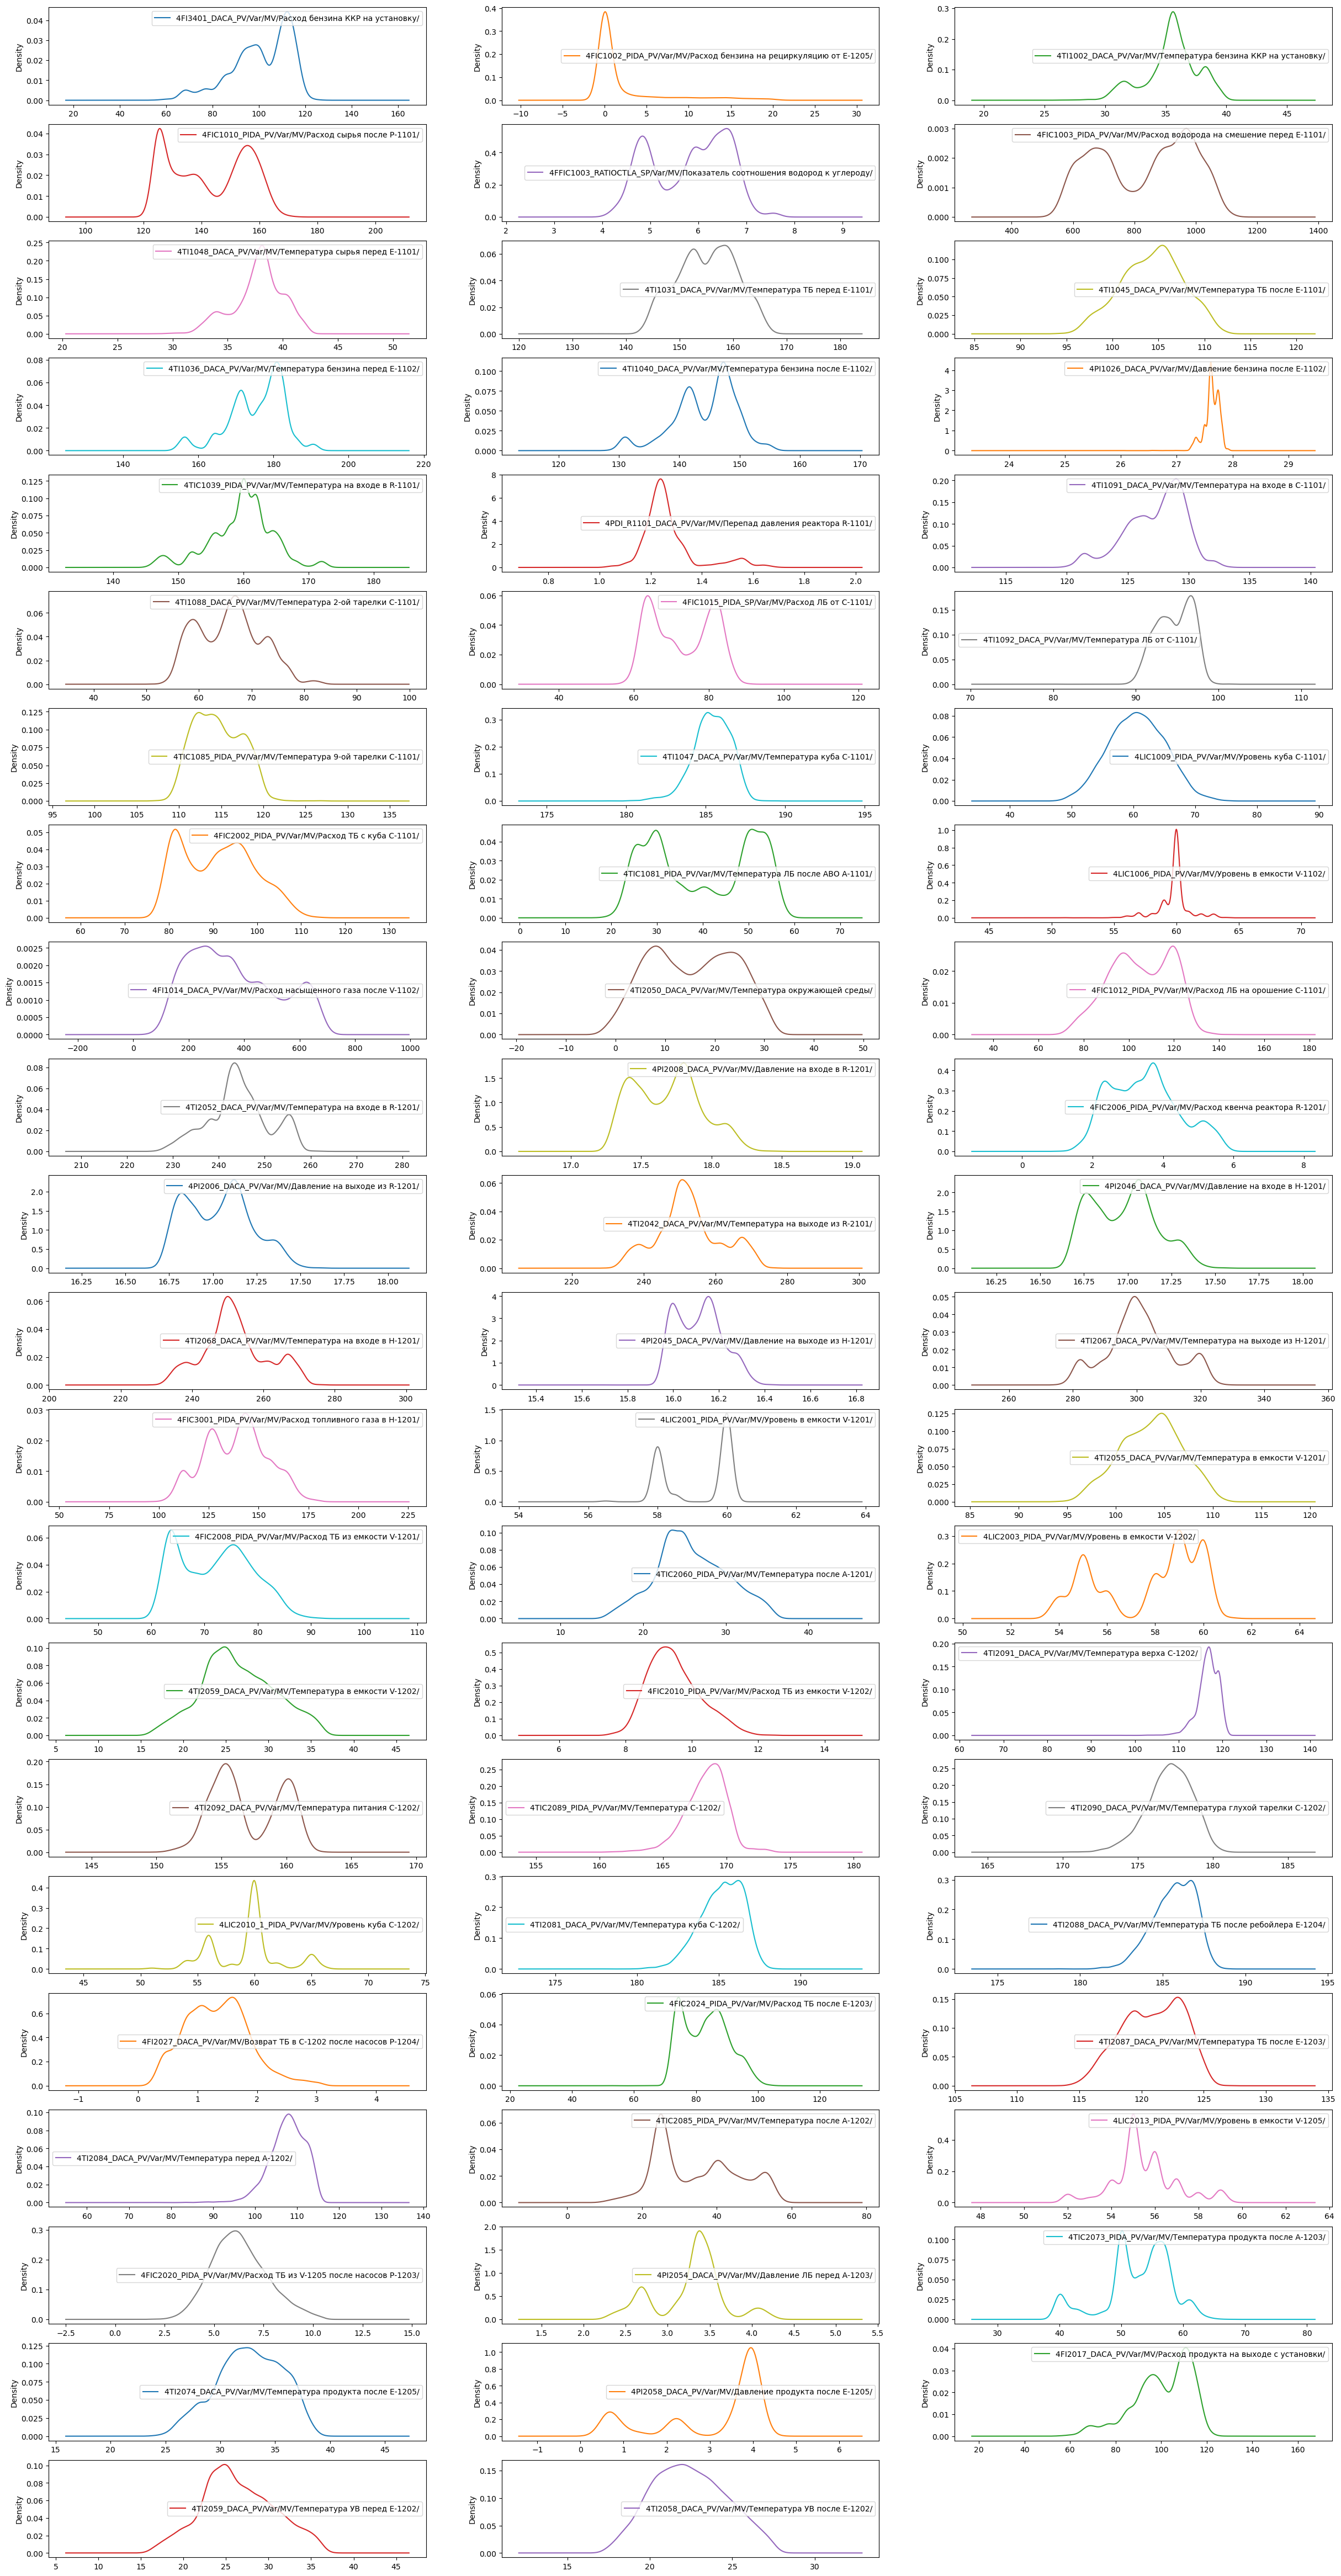

In [16]:
df_X3[df_X3.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

Посмотрим, какая регулярность измерений процессорных данных. Для этого построим гистограмму распределения временного промежутка (в минутах) между двумя соседними измерениями.
Лабораторные анализы проиводились крайне нерегулярно, для них такая диаграмма не имеет смысла.

Counter({Timedelta('0 days 01:27:55'): 3369, Timedelta('0 days 01:29:20'): 1419, Timedelta('0 days 01:27:50'): 1158, Timedelta('0 days 01:25:00'): 1063, Timedelta('0 days 01:00:00'): 715, Timedelta('0 days 02:55:50'): 51, Timedelta('0 days 02:50:00'): 27, Timedelta('0 days 04:23:45'): 27, Timedelta('0 days 02:55:40'): 22, Timedelta('0 days 02:58:40'): 22, Timedelta('0 days 04:23:30'): 19, Timedelta('0 days 05:51:40'): 17, Timedelta('0 days 08:56:00'): 16, Timedelta('0 days 10:25:20'): 15, Timedelta('0 days 04:28:00'): 13, Timedelta('0 days 07:26:40'): 12, Timedelta('0 days 05:57:20'): 11, Timedelta('0 days 07:19:35'): 10, Timedelta('0 days 02:00:00'): 10, Timedelta('0 days 04:15:00'): 7, Timedelta('0 days 05:40:00'): 7, Timedelta('0 days 10:15:25'): 7, Timedelta('0 days 13:24:00'): 7, Timedelta('0 days 11:54:40'): 6, Timedelta('0 days 03:00:00'): 6, Timedelta('0 days 07:05:00'): 5, Timedelta('0 days 05:51:20'): 5, Timedelta('0 days 08:47:00'): 5, Timedelta('0 days 08:47:30'): 5, Timede

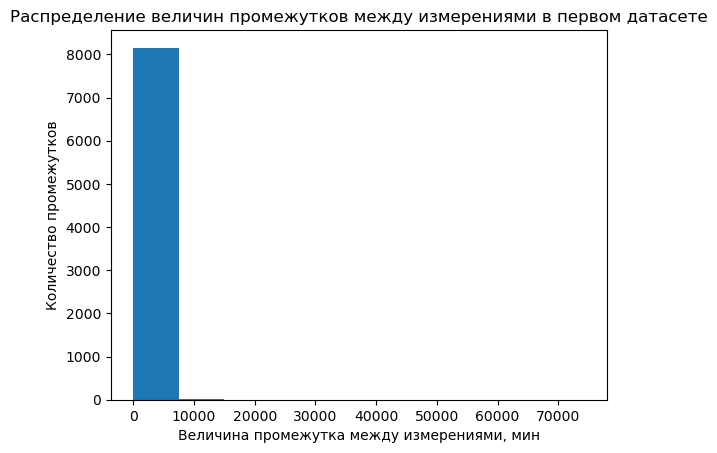

In [17]:
plot_timedelta_distr(df_X1, "Распределение величин промежутков между измерениями в первом датасете")

Как мы видим, даже процессорные измерения были не полностью регулярные, что может сказаться на количестве процессорных значений, соответствующих одному лабораторному анализу

Пройдёмся по нашим процессорным данным и поставим в соответствие лабораторным измерениям те процессорные данные, которые были получены не дальше чем diff времени до лабораторного анализа или diff2 времени после лабораторного анализа

In [18]:
diff1 = pd.to_timedelta('2h')
diff2 = pd.to_timedelta('4h')

Количество точек 134 

Распределение количества примеров 
 Counter({0: 72, 1: 35, 2: 27}) 



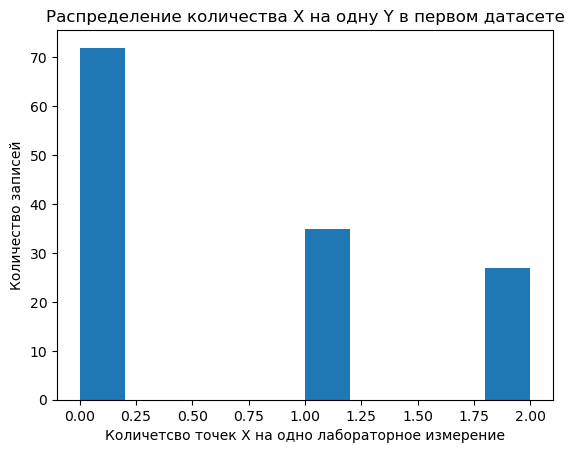

In [19]:
plot_num_distr(construct_XY(df_X1, df_Y1, diff1, diff2), "Распределение количества X на одну Y в первом датасете")

Количество точек 110 

Распределение количества примеров 
 Counter({1: 53, 0: 31, 2: 26}) 



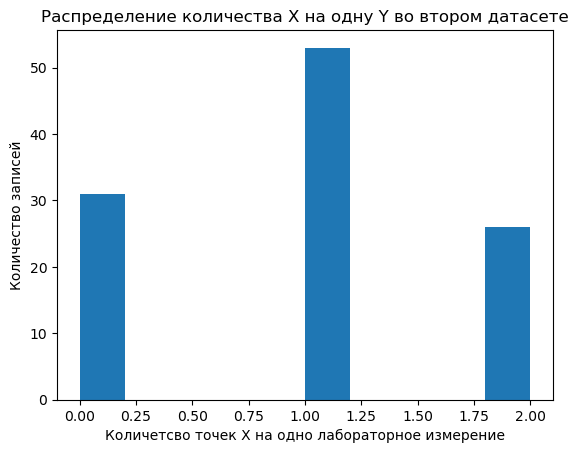

In [20]:
plot_num_distr(construct_XY(df_X2, df_Y2, diff1, diff2), "Распределение количества X на одну Y во втором датасете")

Количество точек 226 

Распределение количества примеров 
 Counter({1: 93, 0: 73, 2: 60}) 



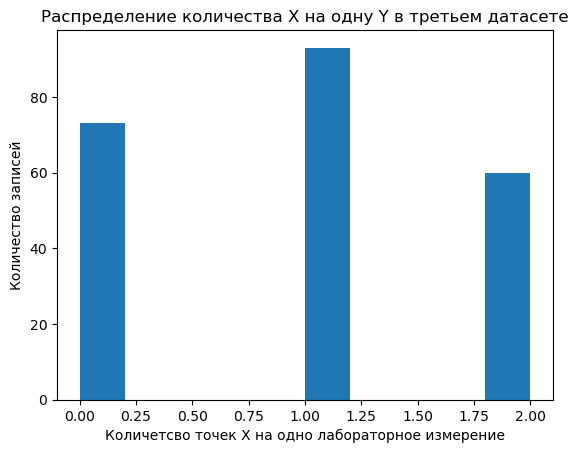

In [21]:
plot_num_distr(construct_XY(df_X3, df_Y3, diff1, diff2), "Распределение количества X на одну Y в третьем датасете")

Как мы видим, при данных временных рамках одному лабораторному анализу может соответствовать от нуля до пяти процессорных данных. Чтобы иметь возможность адекватно обрабатывать данные, необходимо отбросить точки без процессорных данных и свести процессорные данные к единому формату. 
Подобная обработка процессорных данных может быть проделана, используя среднее или экпоенециальное среднее

## Формирование тестовой и обучающей выборки

## Описание функций

Функция формирования тестовой и обучающей выборки в numpy массивов, значения Х в каждой точке агрегируются в вектор. На вход подаётся свежий экземпляр генератора точек X и Y и функция агрегирования

In [22]:
def form_datasets(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    return all_X, all_Y_with_timestamps

def form_datasets_periods(gen, agregate_func) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Формирует 2 numpy.ndarray в порядке x_summer_half, y_summer_half, x_winter_half, y_winter_half,
    значения X получены через функцию агрегирования agregate_func."""

    # Получение первой порции данных из генератора для определения размеров массивов
    try:
        x, y, timestamp = next(gen)  
    except StopIteration:
        # Если генератор не возвращает данных, завершаем функцию и возвращаем пустые массивы
        return (np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0))

    # Инициализируем массивы для записи данных
    x_summer_half = np.array([], dtype=np.float64).reshape(0, x.shape[1])
    x_winter_half = np.array([], dtype=np.float64).reshape(0, x.shape[1])
    y_summer_half = np.array([], dtype='object').reshape(0, len(y) + 1)
    y_winter_half = np.array([], dtype='object').reshape(0, len(y) + 1)

    # Обрабатываем оставшиеся данные
    for x, y, timestamp in gen:
        if len(x) == 0:
            continue
        
        x_agg = agregate_func(x)

        # Распределение данных по выборкам в зависимости от месяца
        if 4 <= timestamp.month <= 9:
            y_summer_half = np.vstack((y_summer_half, np.append(y, timestamp)))
            x_summer_half = np.vstack((x_summer_half, x_agg))
        else:
            y_winter_half = np.vstack((y_winter_half, np.append(y, timestamp)))
            x_winter_half = np.vstack((x_winter_half, x_agg))

    return x_summer_half, y_summer_half, x_winter_half, y_winter_half

def form_datasets_cat(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []
    all_X_season = []  # Создаем список для сезонного столбца

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)
            # Добавляем значение в список сезонного столбца
            all_X_season.append(1 if 4 <= timestamp.month <= 9 else 0)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)
    all_X_season = np.array(all_X_season, dtype=np.float64).reshape(-1, 1)  # Преобразуем список в массив NumPy

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    # Добавляем сезонный столбец к all_X
    all_X = np.hstack((all_X, all_X_season))

    return all_X, all_Y_with_timestamps

Функция агрегирования, обобщающая использование арифметического среднего, последнего значения и взвешенного экпоненциального среднего

In [23]:
def exp_average(arr: np.ndarray, alpha=0) -> np.ndarray:
    """Функция взвешенного среднего для агрегирования значений X. При alpha = 0 результат - арифметическое среднее, 
    при alpha = 1 результат - последнее значение, при alpha = (0, 1) результат - экспоненциальное взвешенное среднее"""

    arr = arr[::-1]
    out_arr = np.zeros(arr.shape[1])
    coeff_sum = 0
    for pow, row in enumerate(arr):
        coeff = (1-alpha)**pow
        out_arr = out_arr + row*coeff
        coeff_sum += coeff
    
    out_arr = out_arr/coeff_sum
    return out_arr

Сохранение данных в .npz архив

In [24]:
def save_datasets(gen1, gen2, gen3, gen2_cat, gen3_cat, func, func_name) -> None:
    """Генерирует и сохраняет датасеты с определённой функцией агрегирования func в .npz архив под именем Data_func_name.npz"""
    
    all_X_1, all_Y_1 = form_datasets(gen1, func)
    x_summer_half_2, y_summer_half_2, x_winter_half_2, y_winter_half_2 = form_datasets_periods(gen2, func)
    x_summer_half_3, y_summer_half_3, x_winter_half_3, y_winter_half_3 = form_datasets_periods(gen3, func)
    all_X_2, all_Y_2 = form_datasets_cat(gen2_cat,func)
    all_X_3, all_Y_3 = form_datasets_cat(gen3_cat,func)
    
    np.savez_compressed(
        "Data_" + func_name +".npz", 
        all_X_1 = all_X_1, all_Y_1=all_Y_1, 
        x_summer_half_2=x_summer_half_2, y_summer_half_2=y_summer_half_2, x_winter_half_2=x_winter_half_2, y_winter_half_2=y_winter_half_2,
        x_summer_half_3=x_summer_half_3, y_summer_half_3=y_summer_half_3, x_winter_half_3=x_winter_half_3, y_winter_half_3=y_winter_half_3,
        all_X_2 = all_X_2, all_Y_2 = all_Y_2,
        all_X_3 = all_X_3, all_Y_3 = all_Y_3
    )
                       

## Сохранение размеченных данных

Сохраним архивы с 3 вариантами агрегирования (арифметическое среднее, последнее измерение, взвешенное экспоненциальное среднее. 

В каждом архиве находятся по 4 массива для 3 виртуальных анализаторов. Номер ВА - последняя цифра в названии массива (1 - Давление насыщенных паров в продукте, зимний период, 2 - Конец кипения легкого бензина, 3 - Содержание олефинов в продукте). 

Каждый массив построен по следующему принципу Y[N], X[N, C], где N - номер точки, C - номер процессорного значения.

In [25]:

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    lambda x: exp_average(x, alpha=0),
    "Average_Nikita"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    lambda x: exp_average(x, alpha=1),
    "First_Nikita"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    lambda x: exp_average(x, alpha=0.5),
    "Exponential_Average_Nikita"
)

In [26]:
df_X1.to_csv('raw_X1.csv')
df_X2.to_csv('raw_X2.csv')
df_X3.to_csv('raw_X3.csv')

df_Y1.to_csv('raw_Y1.csv')
df_Y2.to_csv('raw_Y2.csv')
df_Y3.to_csv('raw_Y3.csv')